# Preprocessing data notebook

### •  The aim of this notebook is to apply preprocessing so we can prepare data for machine learning phase by encoding

### •  Machine undestand only 0 and 1 (numbers) so we need to convert all columns to this formula even if they were categorical

## import libraries that is going to be used in our project 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import random
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
from iso639 import languages
import user_agents
from ip2geotools.databases.noncommercial import DbIpCity as ip2geo
import requests
import json
from geopy.distance import great_circle
from geopy.geocoders import Nominatim
from datasist.structdata import detect_outliers
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
from category_encoders import BinaryEncoder 
from datetime import datetime
from sklearn.model_selection import train_test_split , cross_validate
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE , RandomOverSampler
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import r2_score , mean_squared_error , classification_report ,recall_score , precision_score , ConfusionMatrixDisplay , confusion_matrix
from sklearn.linear_model import Ridge , Lasso
from sklearn.tree import DecisionTreeRegressor , DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor , RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB , GaussianNB , BernoulliNB
from sklearn.svm import SVC , SVR
from sklearn.ensemble import AdaBoostClassifier , GradientBoostingClassifier
import xgboost as xgb
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')
import pickle
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering,KMeans,DBSCAN
from sklearn.decomposition import PCA
%matplotlib inline
from imblearn.base import _ParamsValidationMixin

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## import the cleaned version of data 

In [2]:
raw_data=pd.read_csv('../data/processed/eda_df.csv')
df=raw_data.copy()
df.sample(5)

,Unnamed: 0,age,annual_income,monthly_inhand_salary,interest_rate,num_of_loan,delay_from_due_date,num_of_delayed_payment,num_credit_inquiries,credit_mix,...,credit_utilization_ratio,payment_of_min_amount,total_emi_per_month,amount_invested_monthly,payment_behaviour,monthly_balance,credit_score,credit_history_year,credit_history_month,age_group
39729,39729,55,69.249473,0.000000,12,3,22,11,4.0,Standard,...,31.633656,No,0.000000,270,High_spent_Large_value_payments,1042,Standard,29,3,48-58
49747,49747,27,38493.000000,3060.806667,15,2,22,20,4.0,Standard,...,37.559452,Yes,36.464771,147,High_spent_Small_value_payments,382,Good,7,2,18-28
12911,12911,29,16798.000000,1544.845833,16,3,7,11,0.0,Standard,...,25.108914,Yes,31.318517,30,High_spent_Medium_value_payments,342,Good,9,4,28-38
47610,47610,33,76448.000000,6134.703333,17,3,24,8,6.0,Standard,...,36.957627,NM,141.296715,128,!@9#%8,219,Poor,11,3,28-38
80712,80712,33,21803.000000,1782.995000,20,4,30,15,2.0,Standard,...,29.445524,No,41.619539,90,High_spent_Small_value_payments,306,Standard,0,0,28-38


## drop unnecessary csv column

In [3]:
df.drop(['Unnamed: 0','age_group'],axis=1,inplace=True)

## looking at the general information of the data frame

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   age                       100000 non-null  int64  
 1   annual_income             100000 non-null  float64
 2   monthly_inhand_salary     100000 non-null  float64
 3   interest_rate             100000 non-null  int64  
 4   num_of_loan               100000 non-null  int64  
 5   delay_from_due_date       100000 non-null  int64  
 6   num_of_delayed_payment    100000 non-null  int64  
 7   num_credit_inquiries      100000 non-null  float64
 8   credit_mix                100000 non-null  object 
 9   outstanding_debt          100000 non-null  int64  
 10  credit_utilization_ratio  100000 non-null  float64
 11  payment_of_min_amount     100000 non-null  object 
 12  total_emi_per_month       100000 non-null  float64
 13  amount_invested_monthly   100000 non-null  in

## look at the corroleation between data features

<AxesSubplot:>

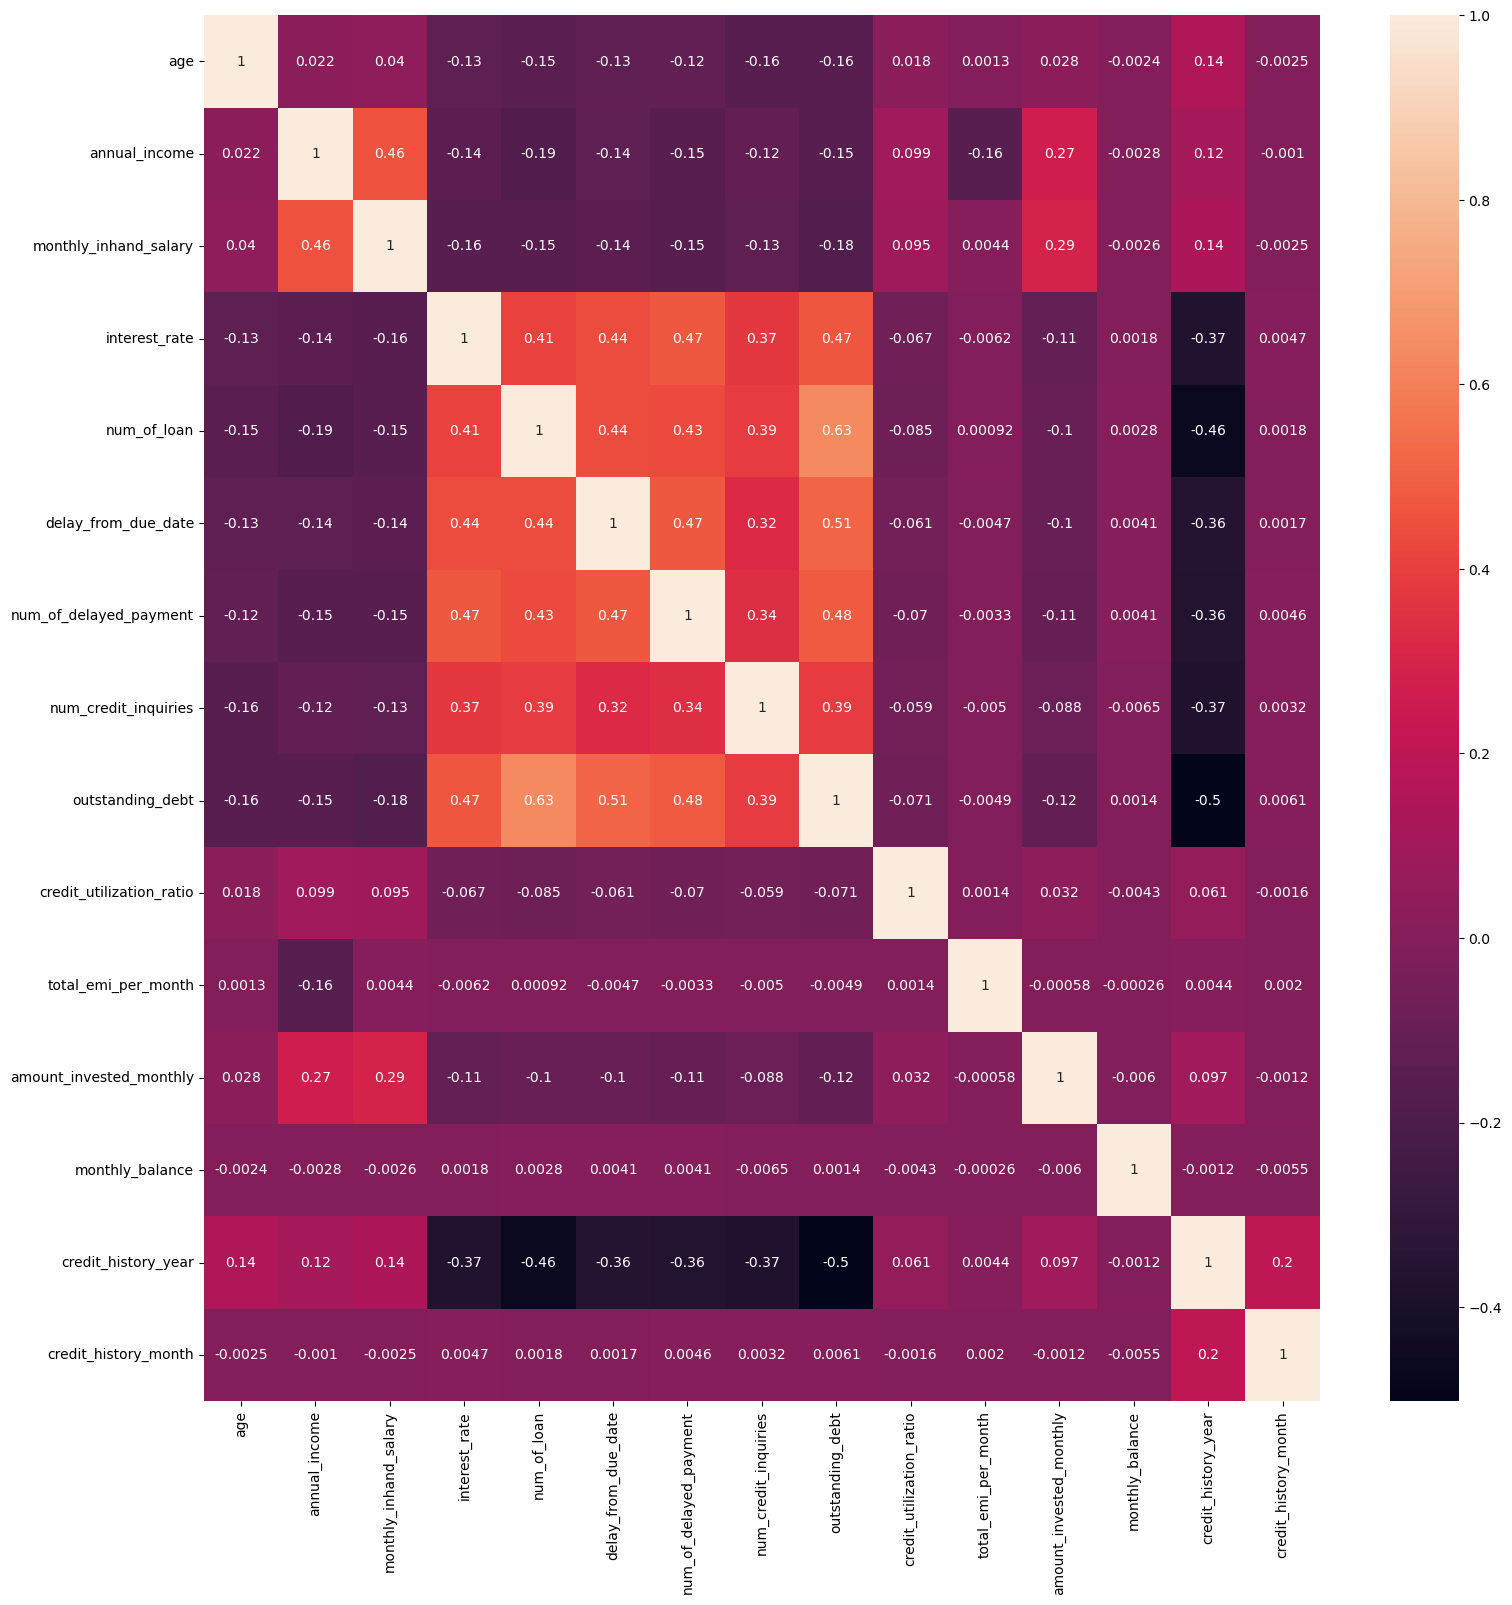

In [5]:
#set the size of the seaborn plot size
plt.figure(figsize=(18, 18))
sns.heatmap(df.select_dtypes('number').corr(), annot=True )

In [6]:
#drop high correlated columns
#we will drop monthly_inhand_salary because it has high correlation with annual_income which make it as dependent feature
df.drop('monthly_inhand_salary',axis=1,inplace=True)

## encoding 

In [7]:
#collect all categorical features which suppose to be converted into numerical values in encoding phase
lst_obj=df.select_dtypes('O').columns.to_list()
lst_obj

['credit_mix', 'payment_of_min_amount', 'payment_behaviour', 'credit_score']

In [8]:
#discover number of special variables and ordering to figure out the strategy of encoding wether it is (label/onehot/binary) encoding
for i in lst_obj:
    print(f'feature {i} : \n',df[i].value_counts())
    print('-'*60)

feature credit_mix : 
 Standard    36479
Good        24337
_           20195
Bad         18989
Name: credit_mix, dtype: int64
------------------------------------------------------------
feature payment_of_min_amount : 
 Yes    52326
No     35667
NM     12007
Name: payment_of_min_amount, dtype: int64
------------------------------------------------------------
feature payment_behaviour : 
 Low_spent_Small_value_payments      25513
High_spent_Medium_value_payments    17540
Low_spent_Medium_value_payments     13861
High_spent_Large_value_payments     13721
High_spent_Small_value_payments     11340
Low_spent_Large_value_payments      10425
!@9#%8                               7600
Name: payment_behaviour, dtype: int64
------------------------------------------------------------
feature credit_score : 
 Standard    53174
Poor        28998
Good        17828
Name: credit_score, dtype: int64
------------------------------------------------------------


## so our decision will be as follwing

## credit_mix column has 4 unique ids and ordering

## payment_of_min_amount columns has 3 ids and no ordering

## payment_behaviour column has 7 ids and ordering

## credit_score column has 3 ids and ordering

## apply label encoding for credit_mix , payment_behaviour and credit_score (the target) columns

## apply one hot encoding for paymeny_of_min_amount

In [10]:
#we have notice there are strange special variables needed to be replace with most frequent id of column
#for payment_behaviour there is ('!@9#%8')
df['payment_behaviour']=df['payment_behaviour'].replace('!@9#%8',df['payment_behaviour'].mode()[0])
#for payment_behaviour there is ('VM')
df['payment_of_min_amount']=df['payment_of_min_amount'].replace('NM',df['payment_of_min_amount'].mode()[0])

In [11]:
#check agian the specail variabels after revamping
for i in lst_obj:
    print(f'feature {i} : \n',df[i].value_counts())
    print('-'*60)

feature credit_mix : 
 Standard    36479
Good        24337
_           20195
Bad         18989
Name: credit_mix, dtype: int64
------------------------------------------------------------
feature payment_of_min_amount : 
 Yes    64333
No     35667
Name: payment_of_min_amount, dtype: int64
------------------------------------------------------------
feature payment_behaviour : 
 Low_spent_Small_value_payments      33113
High_spent_Medium_value_payments    17540
Low_spent_Medium_value_payments     13861
High_spent_Large_value_payments     13721
High_spent_Small_value_payments     11340
Low_spent_Large_value_payments      10425
Name: payment_behaviour, dtype: int64
------------------------------------------------------------
feature credit_score : 
 Standard    53174
Poor        28998
Good        17828
Name: credit_score, dtype: int64
------------------------------------------------------------


## label encoding

In [12]:
#craate the desirable dictionaries to map them with columns later
credit_mix_dic={
    
                    '_':0,
                    'Bad':1,
                    'Standard':2,
                    'Good':3   
}

payment_behaviour_dic={
    
                    'Low_spent_Small_value_payments':0,
                    'Low_spent_Medium_value_payments':1,
                    'High_spent_Small_value_payments':2,
                    'Low_spent_Large_value_payments':3,
                    'High_spent_Medium_value_payments':4,
                    'High_spent_Large_value_payments':5
}

credit_score_dic={
    
                    'Poor':0,
                    'Standard':1,
                    'Good':2
    
}

In [13]:
#map these dictionaries
#collect them in a list
lst_dic=[credit_mix_dic,payment_behaviour_dic,credit_score_dic]
lst_dic

[{'_': 0, 'Bad': 1, 'Standard': 2, 'Good': 3},
 {'Low_spent_Small_value_payments': 0,
  'Low_spent_Medium_value_payments': 1,
  'High_spent_Small_value_payments': 2,
  'Low_spent_Large_value_payments': 3,
  'High_spent_Medium_value_payments': 4,
  'High_spent_Large_value_payments': 5},
 {'Poor': 0, 'Standard': 1, 'Good': 2}]

In [14]:
lst_label=lst_obj.copy()
lst_label.remove('payment_of_min_amount')
lst_label

['credit_mix', 'payment_behaviour', 'credit_score']

In [16]:
for i in range(len(lst_label)):
    df[lst_label[i]]=df[lst_label[i]].map(lst_dic[i])

In [17]:
#check general information after apply the first type of encoding
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   age                       100000 non-null  int64  
 1   annual_income             100000 non-null  float64
 2   interest_rate             100000 non-null  int64  
 3   num_of_loan               100000 non-null  int64  
 4   delay_from_due_date       100000 non-null  int64  
 5   num_of_delayed_payment    100000 non-null  int64  
 6   num_credit_inquiries      100000 non-null  float64
 7   credit_mix                100000 non-null  int64  
 8   outstanding_debt          100000 non-null  int64  
 9   credit_utilization_ratio  100000 non-null  float64
 10  payment_of_min_amount     100000 non-null  object 
 11  total_emi_per_month       100000 non-null  float64
 12  amount_invested_monthly   100000 non-null  int64  
 13  payment_behaviour         100000 non-null  in

## one hot encoding

In [19]:
dummies=pd.get_dummies(df['payment_of_min_amount'])
df=pd.concat([df,dummies],axis=1)
#drop the orginal column
df.drop('payment_of_min_amount',axis=1,inplace=True)

In [20]:
#check general information after apply the second type of encoding
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   age                       100000 non-null  int64  
 1   annual_income             100000 non-null  float64
 2   interest_rate             100000 non-null  int64  
 3   num_of_loan               100000 non-null  int64  
 4   delay_from_due_date       100000 non-null  int64  
 5   num_of_delayed_payment    100000 non-null  int64  
 6   num_credit_inquiries      100000 non-null  float64
 7   credit_mix                100000 non-null  int64  
 8   outstanding_debt          100000 non-null  int64  
 9   credit_utilization_ratio  100000 non-null  float64
 10  total_emi_per_month       100000 non-null  float64
 11  amount_invested_monthly   100000 non-null  int64  
 12  payment_behaviour         100000 non-null  int64  
 13  monthly_balance           100000 non-null  in

In [21]:
df

,age,annual_income,interest_rate,num_of_loan,delay_from_due_date,num_of_delayed_payment,num_credit_inquiries,credit_mix,outstanding_debt,credit_utilization_ratio,total_emi_per_month,amount_invested_monthly,payment_behaviour,monthly_balance,credit_score,credit_history_year,credit_history_month,No,Yes
0,23,19114.0,3,4,3,7,4.0,0,809,26.822620,49.574949,80,2,312,2,22,1,1,0
1,23,19114.0,3,4,18,13,4.0,3,809,31.944960,49.574949,118,3,284,2,0,0,1,0
2,33,19114.0,3,4,3,7,4.0,3,809,28.609352,49.574949,81,1,331,2,22,3,1,0
3,23,19114.0,3,4,5,4,4.0,3,809,31.377862,49.574949,199,0,223,2,22,4,1,0
4,23,19114.0,3,4,6,13,4.0,3,809,24.797347,49.574949,41,4,341,2,22,5,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,25,39628.0,7,2,23,7,3.0,0,502,34.663572,35.104023,60,5,479,0,31,6,1,0
99996,25,39628.0,7,2,18,7,3.0,0,502,40.565631,35.104023,54,4,496,0,31,7,1,0
99997,25,39628.0,13,2,27,6,3.0,3,502,41.255522,35.104023,24,5,516,0,31,8,1,0
99998,25,39628.0,7,2,20,13,3.0,3,502,33.638208,35.104023,251,3,319,1,31,9,1,0


## make sure there is no categorical features has been left

In [27]:
lst_rest=[]
for i in df.columns:
    #if type(df[i]) == 'object'
    if df[i].dtypes == 'object':
        lst_rest.append(i)
if len(lst_rest) == 0 :
    print('there is no categorical features has been left')
else :
    print('there is categorical features has been left')

there is no categorical features has been left


## extract clean version of df to be used in our next phases with encoding= 'latin-1' to avoid any kind of errors 

In [28]:
df.to_csv('../data/processed/preprocessed_df.csv',encoding = 'latin-1')